In [13]:
import pandas as pd
import seaborn as sns
import matplotlib as pyplot
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from nltk import word_tokenize
import nltk.stem as stem
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec
import gensim
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.linear_model import LinearRegression

In [2]:
data_train = "Data_Train.csv"
data_test = "Data_Test.csv"

In [3]:
df_train = pd.read_csv("Data/" + data_train)
# df_test = pd.read_csv("Data/" + data_test)
df_train.head()

,Title,Author,Edition,Reviews,Ratings,Synopsis,Genre,BookCategory,Price
0,The Prisoner's Gold (The Hunters 3),Chris Kuzneski,"Paperback,– 10 Mar 2016",4.0 out of 5 stars,8 customer reviews,THE HUNTERS return in their third brilliant no...,Action & Adventure (Books),Action & Adventure,220.00
1,Guru Dutt: A Tragedy in Three Acts,Arun Khopkar,"Paperback,– 7 Nov 2012",3.9 out of 5 stars,14 customer reviews,A layered portrait of a troubled genius for wh...,Cinema & Broadcast (Books),"Biographies, Diaries & True Accounts",202.93
2,Leviathan (Penguin Classics),Thomas Hobbes,"Paperback,– 25 Feb 1982",4.8 out of 5 stars,6 customer reviews,"""During the time men live without a common Pow...",International Relations,Humour,299.00
3,A Pocket Full of Rye (Miss Marple),Agatha Christie,"Paperback,– 5 Oct 2017",4.1 out of 5 stars,13 customer reviews,A handful of grain is found in the pocket of a...,Contemporary Fiction (Books),"Crime, Thriller & Mystery",180.00
4,LIFE 70 Years of Extraordinary Photography,Editors of Life,"Hardcover,– 10 Oct 2006",5.0 out of 5 stars,1 customer review,"For seven decades, ""Life"" has been thrilling t...",Photography Textbooks,"Arts, Film & Photography",965.62


In [4]:
# df_train.shape, df_test.shape

In [5]:
# df_train.shape, df_test.shape

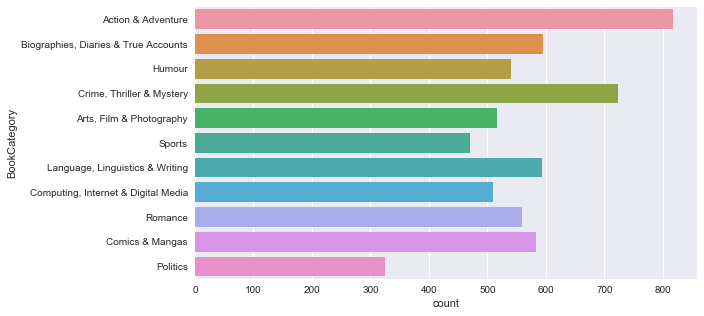

In [6]:
fig, ax = pyplot.pyplot.subplots(figsize=(9,5))
sns.set(style="whitegrid")
sns.countplot(ax=ax, y="BookCategory", data=df_train)
pyplot.pyplot.show()

In [9]:
# sns.distplot(df_train['Reviews']);
# pyplot.pyplot.show()

Text variables : Title, sysnopsis

Categorical : Author, genre, bookCategory

composite (categorical) : Edition

real valued: Reviews, ratings

In [10]:
def prepare_train_test(df_train, df_test):
    df_train['Ratings'] = df_train.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')
    df_test['Ratings'] = df_test.Ratings.str.split().str.get(0).str.replace(',', '').astype('int32')

    df_train['Reviews'] = df_train.Reviews.str.split().str.get(0).astype('float')
    df_test['Reviews'] = df_test.Reviews.str.split().str.get(0).astype('float')

    df_train['Edition_type'] = df_train.Edition.str.split(',').str.get(0)
    df_test['Edition_type'] = df_test.Edition.str.split(',').str.get(0)

    df_train['Edition_year'] = df_train.Edition.str.split().str.get(-1)
    df_test['Edition_year'] = df_test.Edition.str.split().str.get(-1)

    df_train = df_train.drop(columns=['Edition'])
    df_test = df_test.drop(columns=['Edition'])

    # df_train.head()

    # df_train['Genre'].unique().shape

    # df_train['BookCategory'].unique().shape

    # df_train['Author'].unique().shape

    # df['Author'].value_counts()

    stemmer = stem.PorterStemmer()
    stop_words = stopwords.words('english')

    def stem_stop(input_text):

        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(input_text.lower())
        tokens = [x for x in tokens if not x in stop_words]
        tokens_stemmed = [stemmer.stem(x) for x in tokens]
        return tokens_stemmed

    sentences_train = list(df_train['Synopsis'])
    sentences_test = list(df_test['Synopsis'])

    sentences_train = [stem_stop(i) for i in sentences_train]
    sentences_test = [stem_stop(i) for i in sentences_test]

    model = gensim.models.KeyedVectors.load_word2vec_format('models/GoogleNews-vectors-negative300.bin', binary=True)

    def get_mean_vector(word2vec_model, words):
        words = [word for word in words if word in word2vec_model.vocab]
        if len(words) >= 1:
            return np.mean(word2vec_model[words], axis=0)
        else:
            return np.zeroes(300)

    synopsis_train = np.array([get_mean_vector(model, i) for i in sentences_train])
    synopsis_test = np.array([get_mean_vector(model, i) for i in sentences_test])

    synopsis_train.shape

    def get_one_hot_new1(data_train, data_test):
        unique_values = list(data_train.unique())
        unique_values = {j:i for i, j in enumerate(unique_values)}
        total_train = []
        total_test = []
        for i in list(data_train):
            val = None
            if i in unique_values:
                val = unique_values[i]
            else:
                val = len(unique_values)
            x = [0] * (len(unique_values)+1)
            x[val] = 1
            total_train.append(x)

        for i in list(data_test):
            val = None
            if i in unique_values:
                val = unique_values[i]
            else:
                val = len(unique_values)
            x = [0] * (len(unique_values)+1)
            x[val] = 1
            total_test.append(x)
        return np.array(total_train), np.array(total_test)

    genre_train, genre_test = get_one_hot_new1(df_train['Genre'], df_test['Genre'])

    book_train, book_test = get_one_hot_new1(df_train['BookCategory'], df_test['BookCategory'])

    author_train, author_test = get_one_hot_new1(df_train['Author'], df_test['Author'])

    edition_type_train, edition_type_test = get_one_hot_new1(df_train['Edition_type'], df_test['Edition_type'])

    edition_year_train, edition_year_test = get_one_hot_new1(df_train['Edition_year'], df_test['Edition_year'])

#     edition_year_train.shape

    x_train = np.concatenate((df_train[['Ratings', 'Reviews']], genre_train, book_train, author_train, edition_type_train, edition_year_train, synopsis_train), axis=1)

    x_test = np.concatenate((df_test[['Ratings', 'Reviews']], genre_test, book_test, author_test, edition_type_test, edition_year_test, synopsis_test), axis=1)


#     x_train.shape, x_test.shape

    y_train = df_train['Price']
    y_test = df_test['Price']
#     y.shape
    return x_train, x_test, y_train, y_test

In [11]:
x_train, x_test, y_train, y_test = prepare_train_test(df_train[:int(0.8*len(df_train))], df_train[int(0.8*len(df_train)):])

In [12]:
pickle.dump(x_train, open('X_train.pkl', 'wb'))
pickle.dump(x_test, open('X_valid.pkl', 'wb'))
pickle.dump(y_train, open('Y_train.pkl', 'wb'))
pickle.dump(y_test, open('Y_valid.pkl', 'wb'))

In [14]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((4989, 3807), (1248, 3807), (4989,), (1248,))

In [20]:
reg = LinearRegression(normalize=True).fit(x_train, y_train)

In [21]:
reg.score(x_train, y_train)

0.9221357937530842

In [22]:
reg.predict(x_test)

array([ 4.32250000e+02, -6.32232491e+14,  1.27875000e+02, ...,
       -1.15250000e+02, -6.32232491e+14, -2.45000000e+01])

In [23]:
reg.score(x_test, y_test)

-2.0133129185207594e+26